# Overview

This is a Jupyter notebook (work in progress) to visualize the data gathered during our testing with the SATURN patch.

The basic data filtering approach will be as follows:

For each dataset containing a time series of voltage readings:
1. Trim the dataset's beginning and end for "dead zones" where there is no data.
2. Smooth the dataset by taking the moving average.
3. Split the dataset into individual segments, since one dataset typically contains 5 individual readings of 1 gesture.
    
Then the data can be visualized. We're trying a few different approaches:
* [All Data](#All-Data) contains a list of the raw waveforms for all datasets. Useful for debugging.
* [All Data, Sliced and Overlaid](#All-Data--Sliced-and-Overlaid) contains a chart for each waveform containing all the segments, adjusted to be the same length and overlaid upon each other. Useful for validating that input data is consistent.
* [Segments by Gesture](#Segments-by-Gesture) contains a chart for each gesture. In each gesture chart, the segmented data from each configuration of SATURN (ex. with backing material, without backing material, large pad, small pad, etc.) is overlaid. This will help us determine what SATURN configurations produce the most differentiable signals.

# Imports and Utility Functions

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Returns a list of the datasets in the data directory.
# Each dataset in this list is a dict with three attributes:
#   Dir: directory under data/ occupied by this dataset
#   File: filename without extension
#   Path: relative path to .csv
def get_available_datasets():
    data = []

    for datafile in os.popen('find ./data -type f -name *.csv').read().split('\n')[0:-1]:
        n = datafile.split('/')
        data.append({
            'Dir': n[-2],
            'File': n[-1].split('.')[0],
            'Path': datafile
        })

    return data

# Returns a dataset's contents as a list.
# If `raw` is not set, the results will be filtered and normalized.
def load_dataset(datum, raw=False):
    dataset = pd.read_csv(datum['Path'], names=['V'], header=None)
    dataset = list(dataset['V'])
    if not raw:  # normalize and filter the data
        dataset = normalize_dataset(dataset)
        dataset = trim_dataset(dataset)
        dataset = moving_average(dataset, 20)
        #dataset = segment_dataset(dataset, threshold=0.01, min_spacing=100)
    return dataset

# Normalize a dataset by dividing by max amplitude.
def normalize_dataset(data):
    return np.divide(data, np.max(data))

# Removes all leading and trailing points that fall under a certain threshold.
# The idea is to remove the irrelevant start and end portions of our data.
# Returns the relevant slice.
def trim_dataset(data, threshold=0.01):
    i = 0
    while abs(data[i]) < threshold and i < len(data):
        i += 1
    j = len(data) - 1
    while abs(data[j]) < threshold and j > i:
        j -= 1
    return data[i:j]

# Returns a list of the contiguous segments of the dataset.
# A contiguous segment is defined as some slice separated by at least 
# `min_spacing` points where the signal is less than `threshold` from 
# the next segment.
# Returns a list of lists (segments)
def segment_dataset(data, threshold=0.01, min_spacing=100):
    i = 0
    spaces = 0
    intervals = []
    start = None
    while i < len(data):
        while abs(data[i]) < threshold and i < len(data): 
            i += 1
        start = i
        spaces = 0
        end = i
        while i < len(data):
            if abs(data[i]) < threshold:
                spaces += 1
            else:
                spaces = 0
                end = i
            if spaces > min_spacing:
                intervals.append((start, end))
                start = None
                end = None
    if start and not end:
        intervals.append((start, i))
    print(intervals)
    return [data[interval[0]:interval[1]] for interval in intervals]

# Given a `data` as a list and a `window_size` number, it will return
# `data` with each point averaged with the previous `window_size` points.
def moving_average(data, window_size):
    res = []
    for (i,t) in enumerate(data):
        if i == 0:
            continue
        start = i - window_size
        if start < 0:
            start = 0
        end = i
        sl = data[start:end]
        x = np.average(sl)
        res.append(x)
    return res

data = get_available_datasets()

plt.rcParams["figure.figsize"] = (20,8)  # change size of charts

# All Data

/home/zach/.config/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


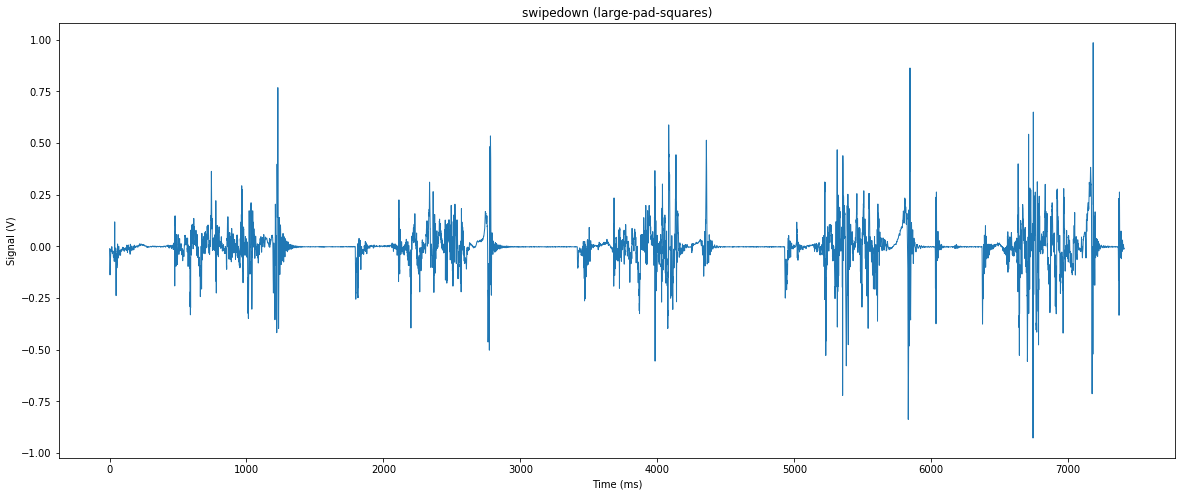

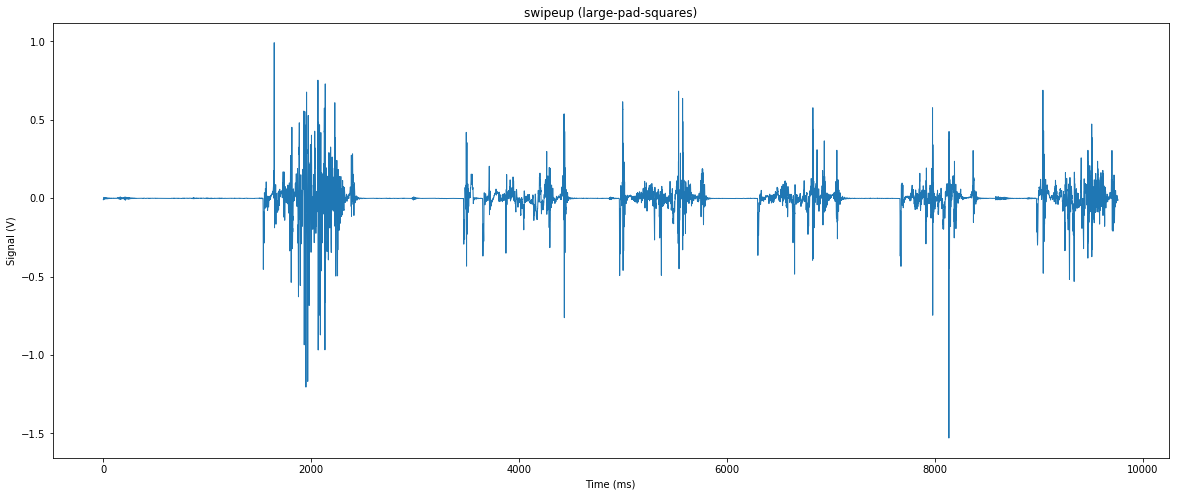

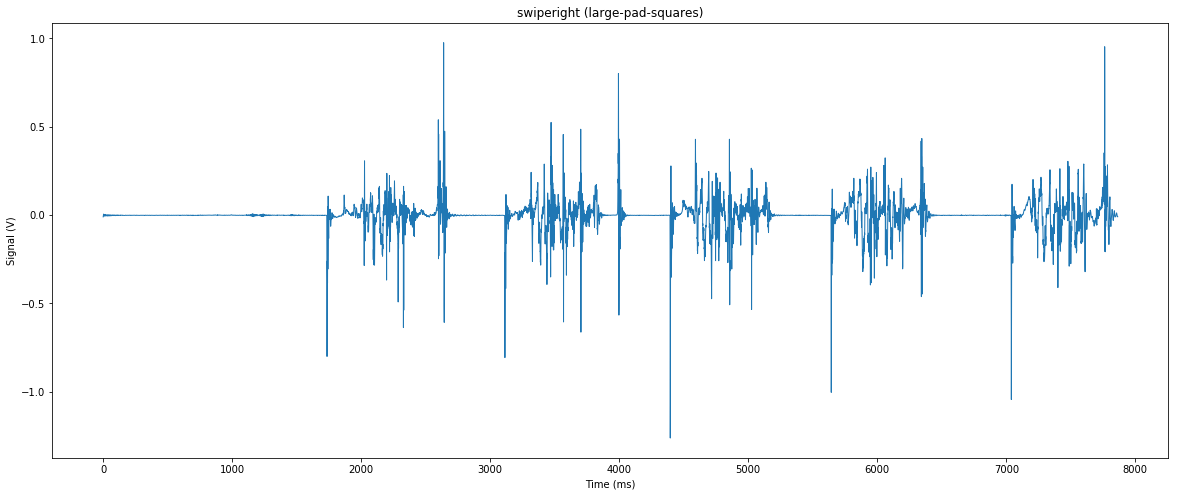

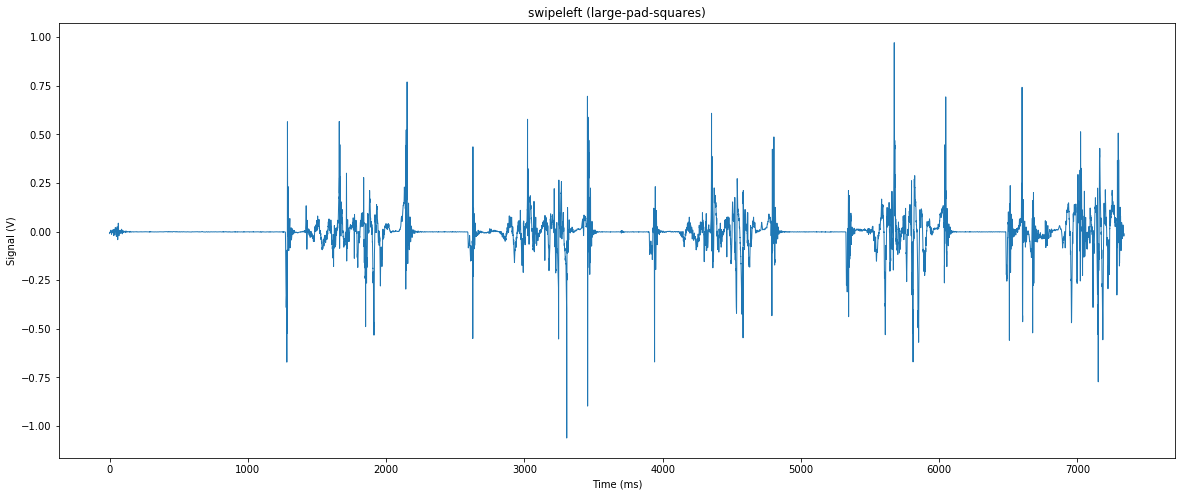

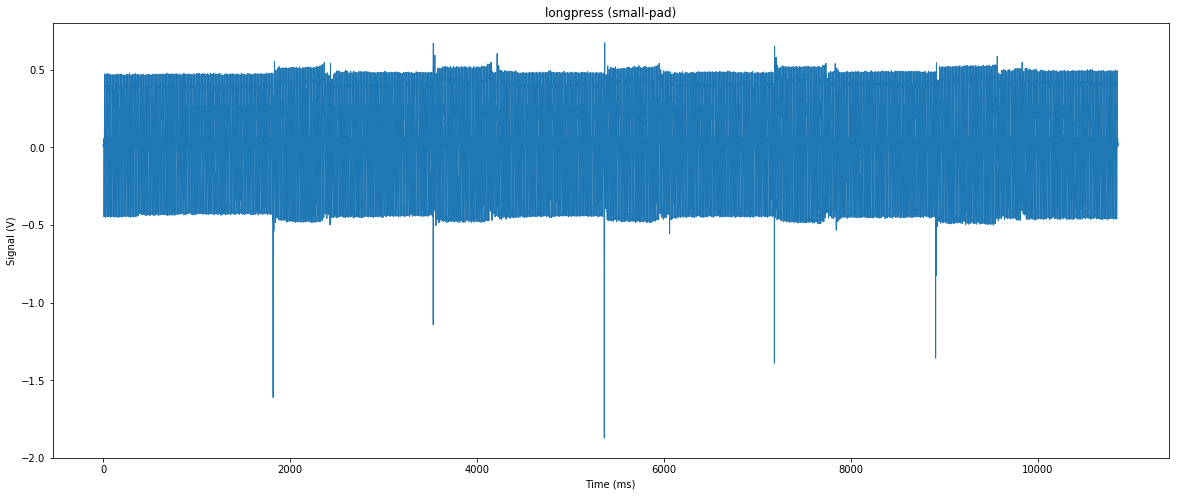

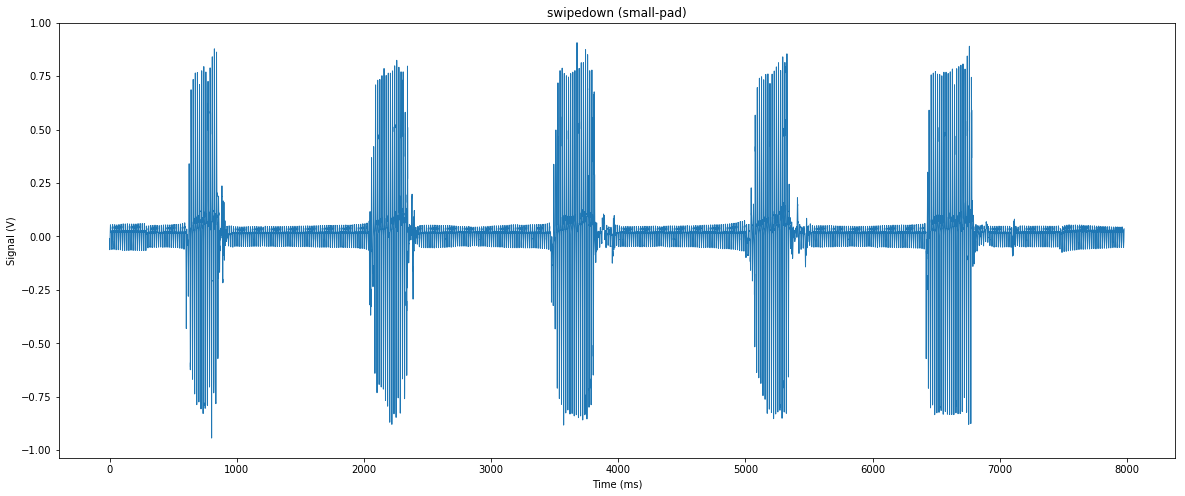

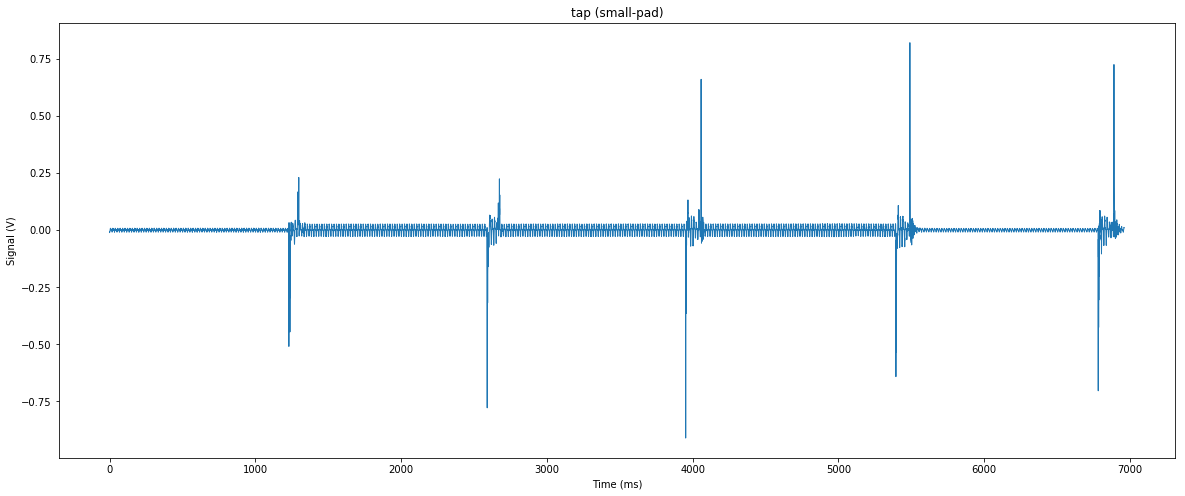

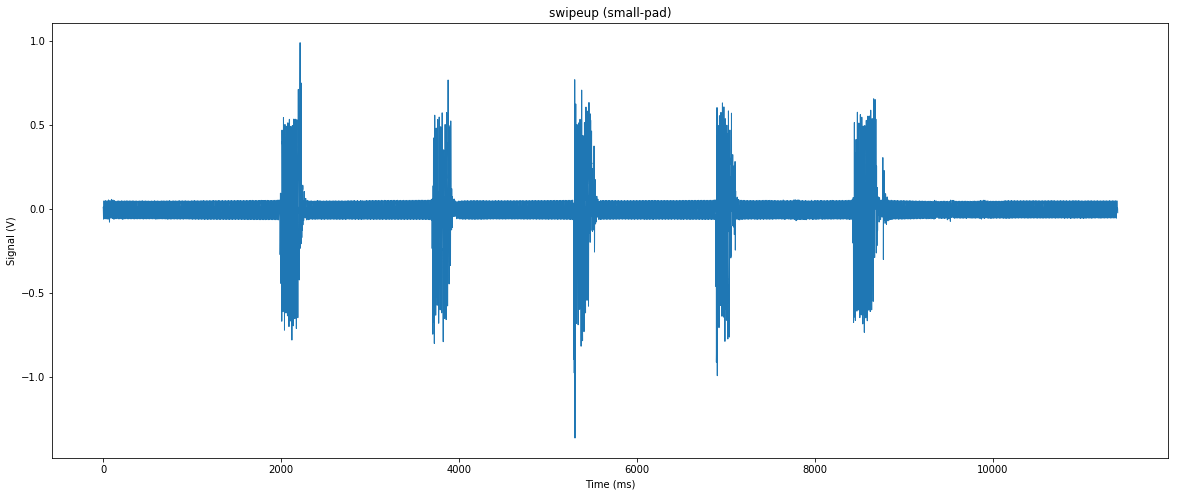

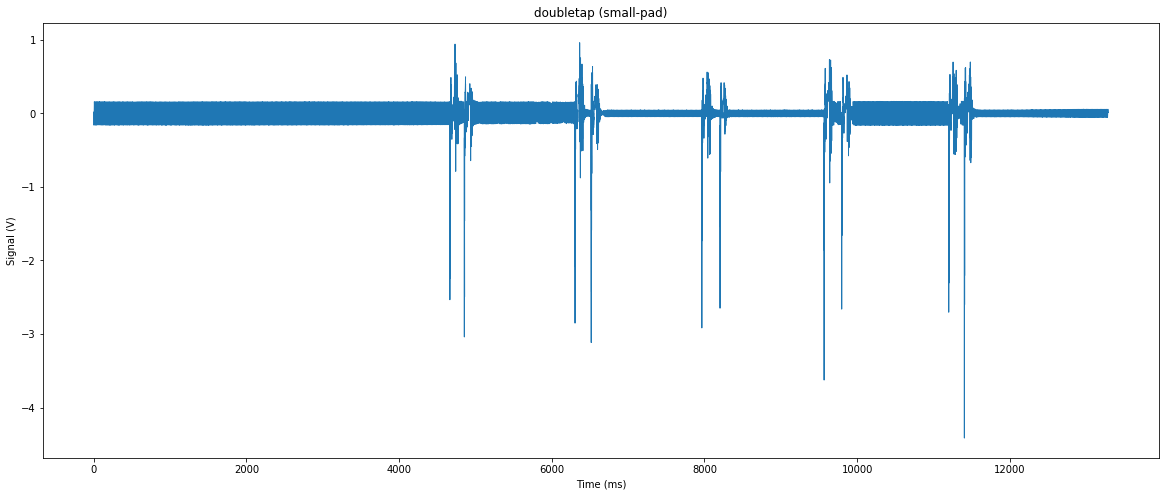

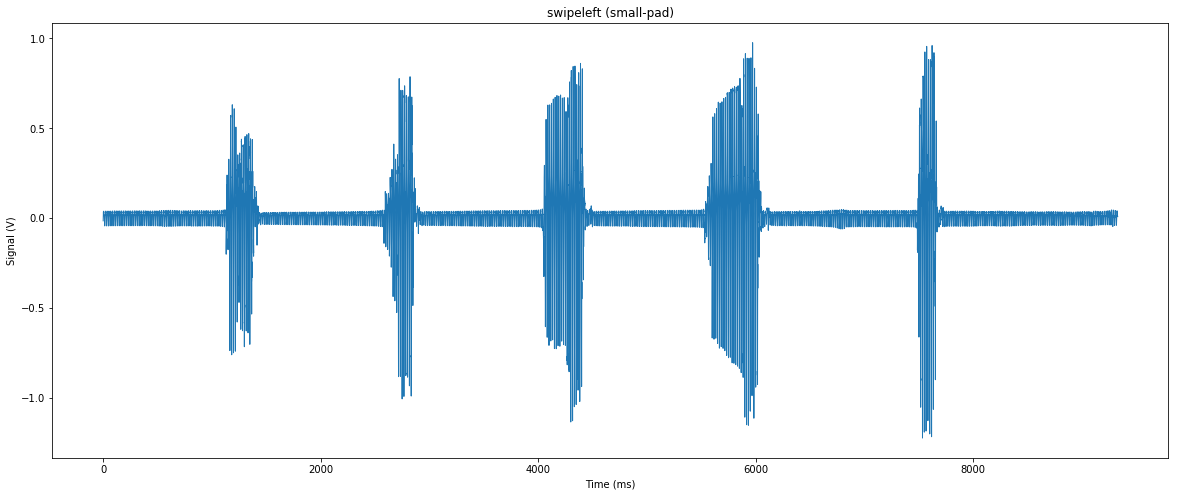

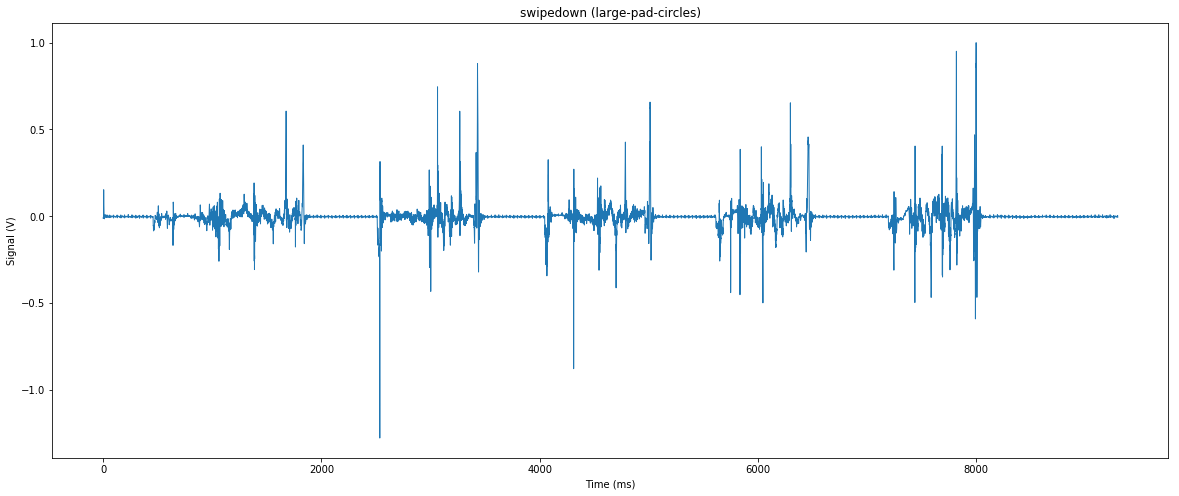

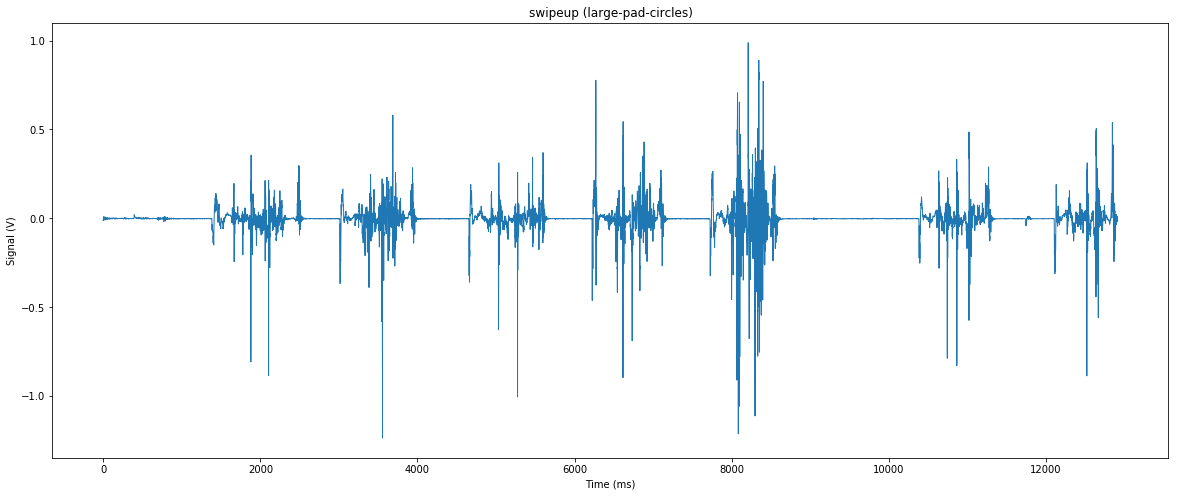

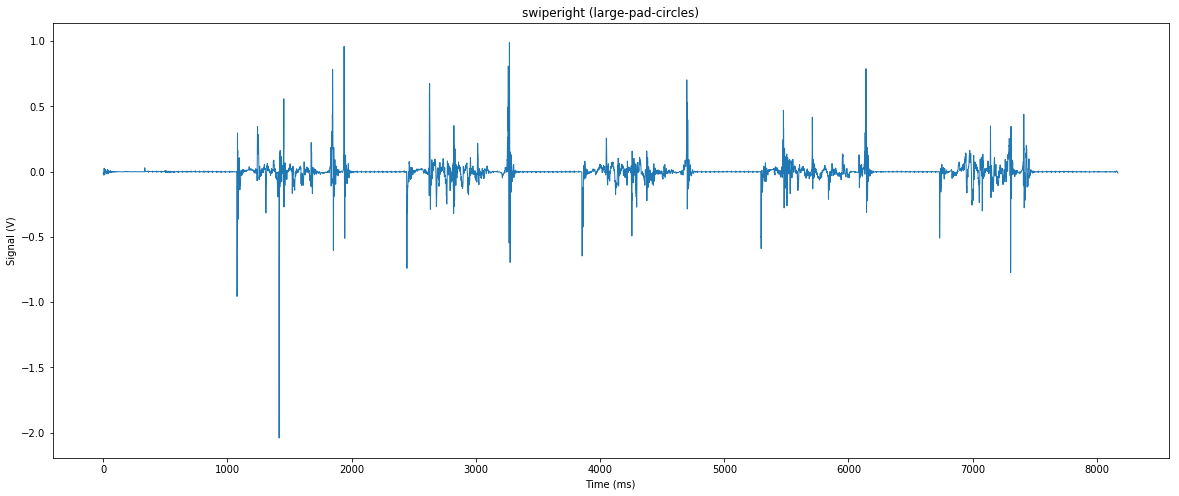

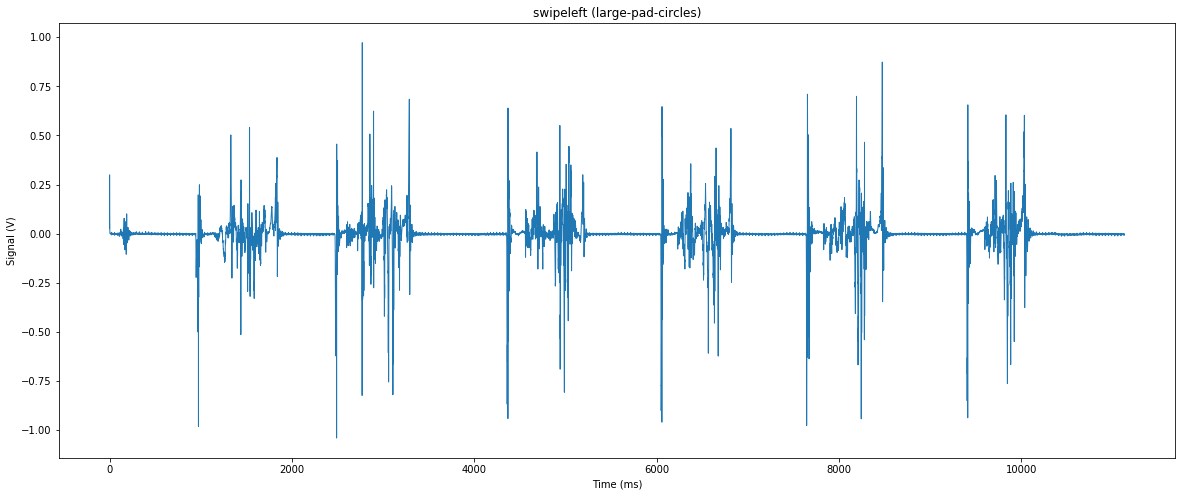

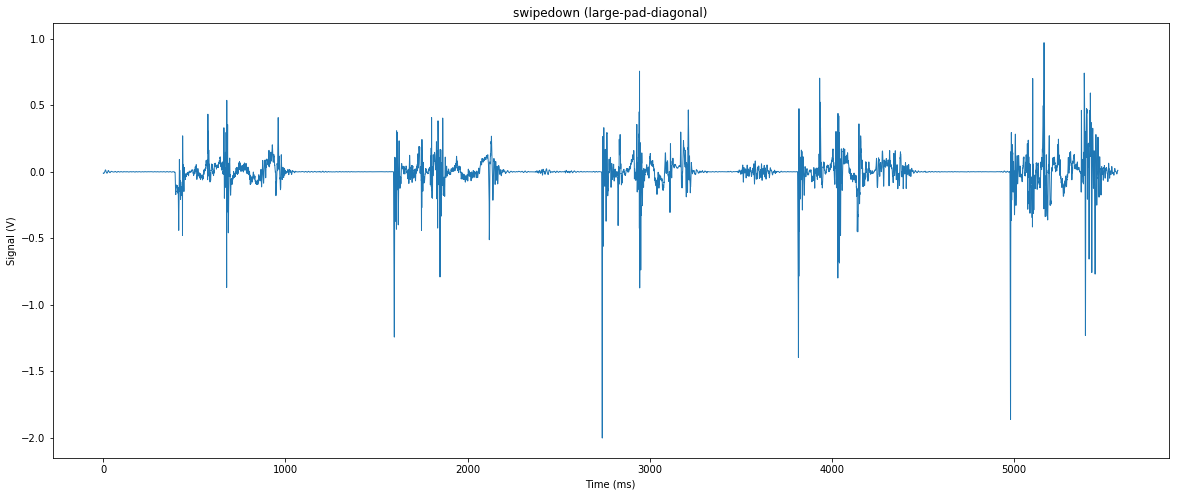

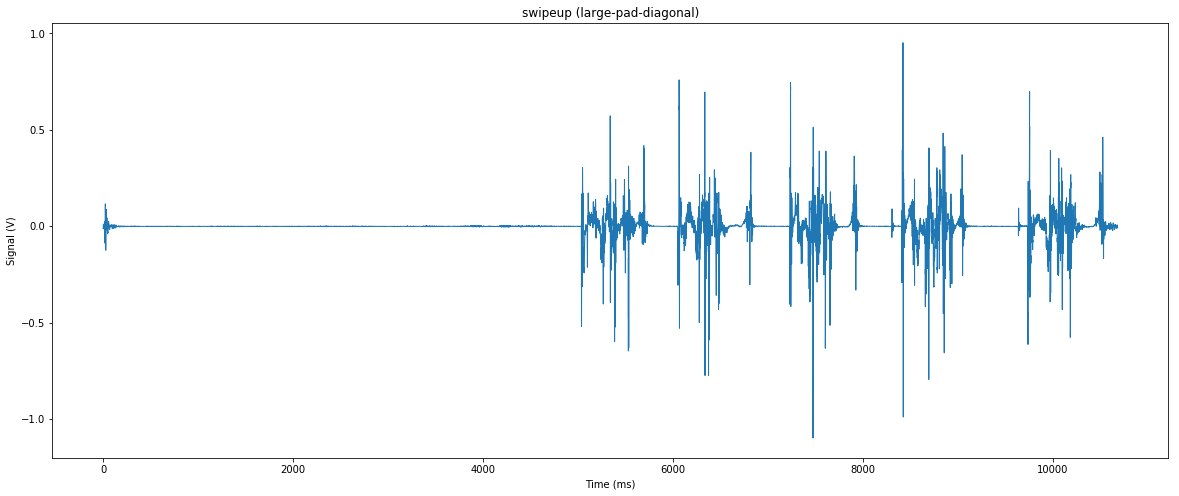

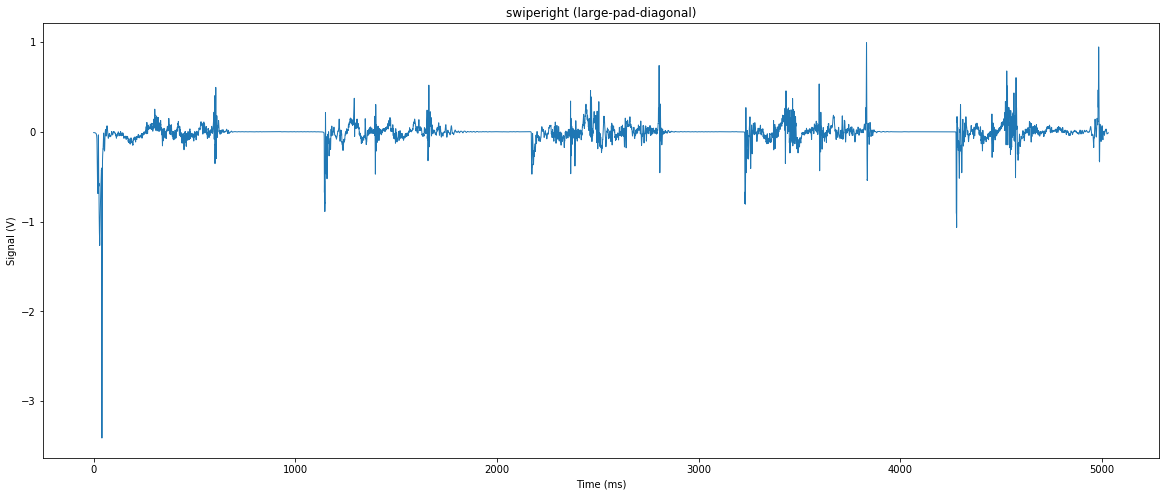

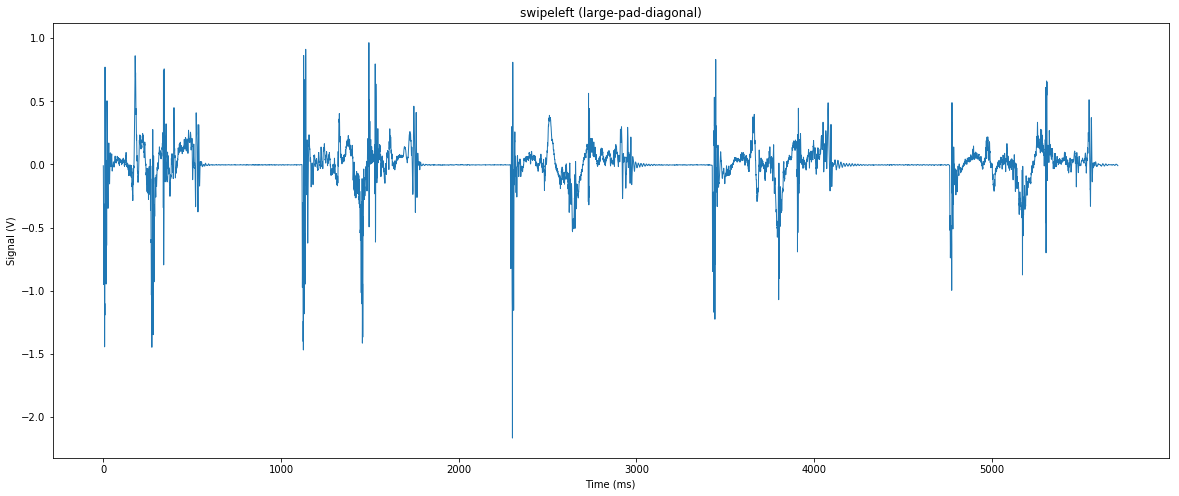

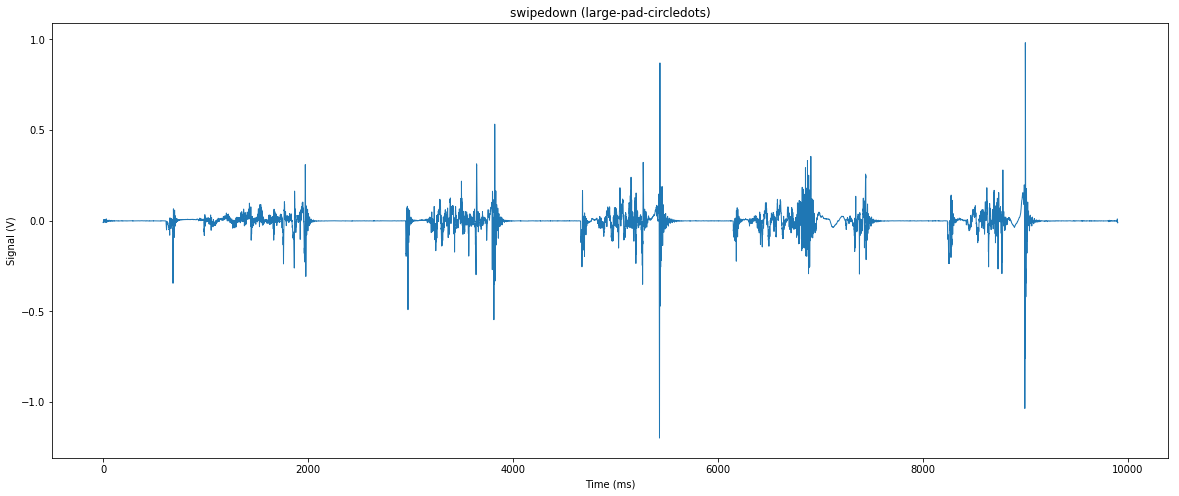

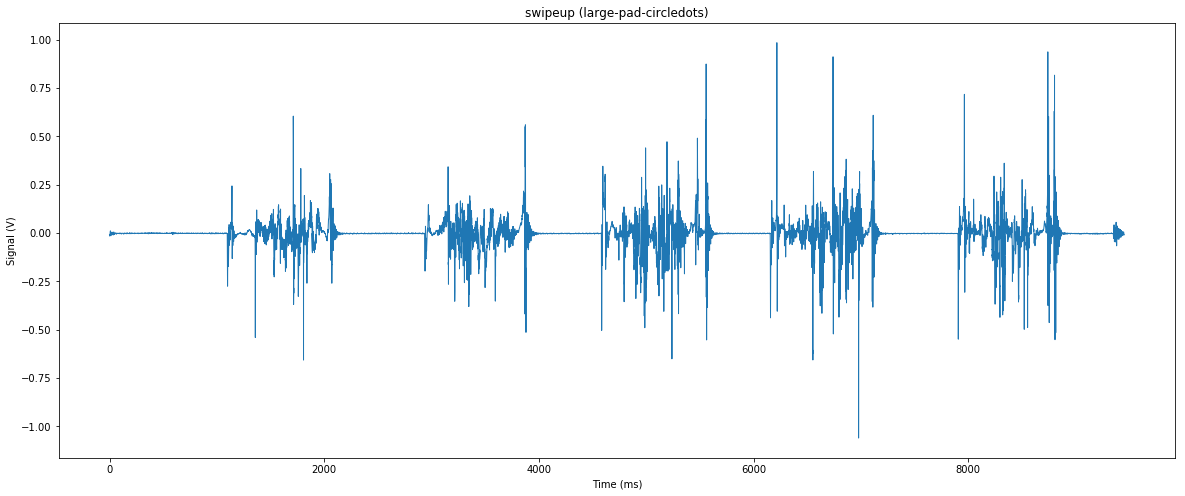

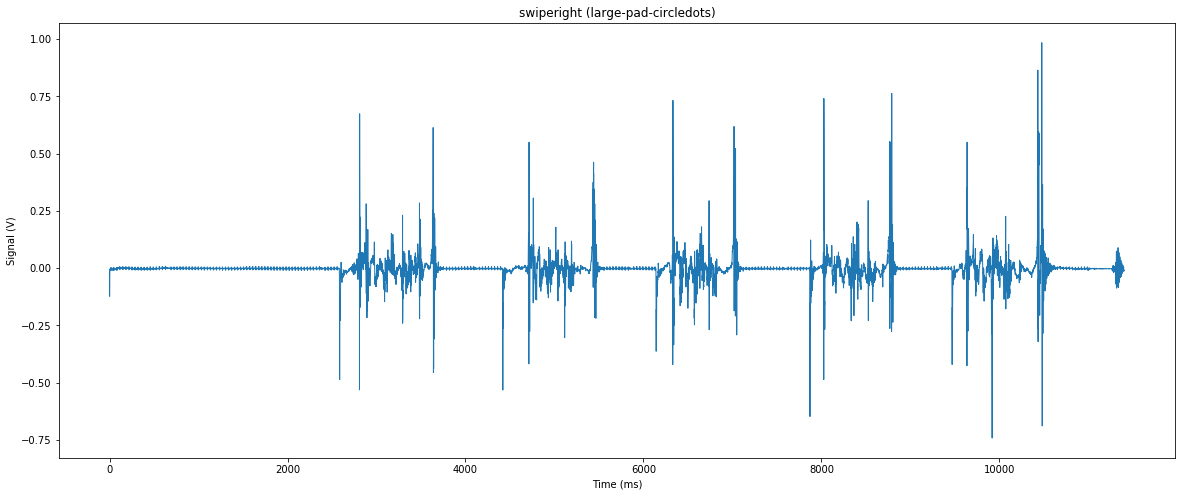

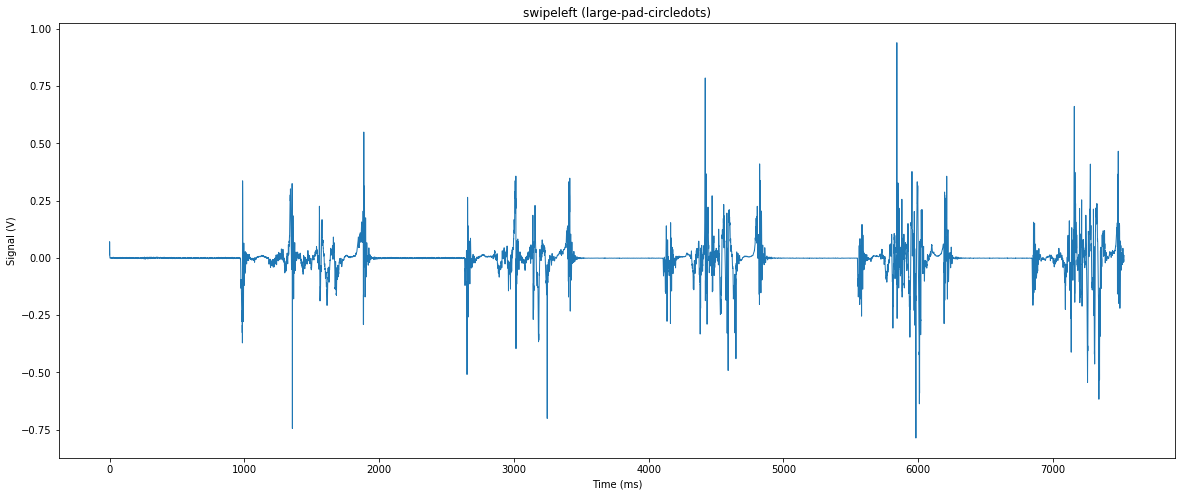

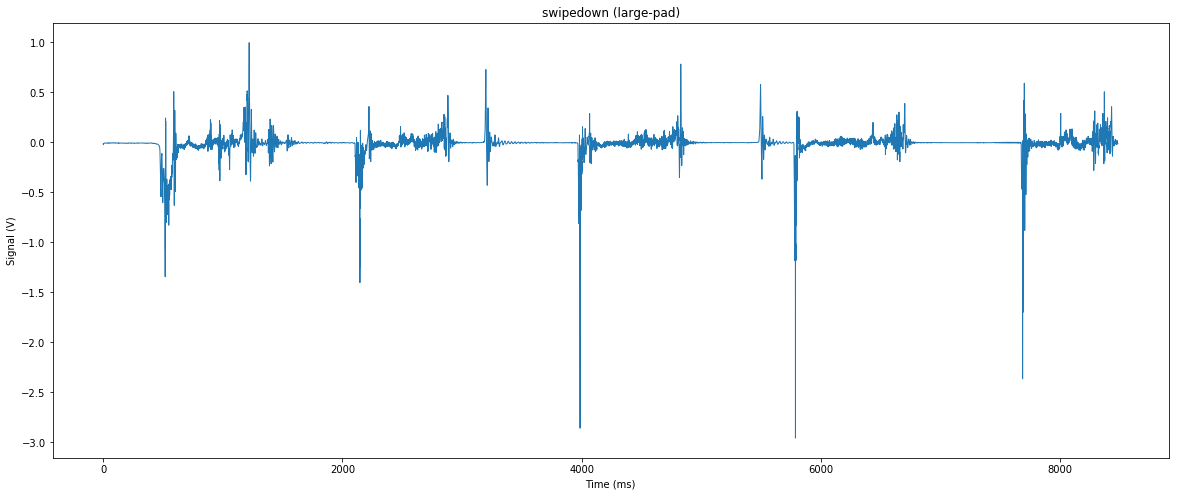

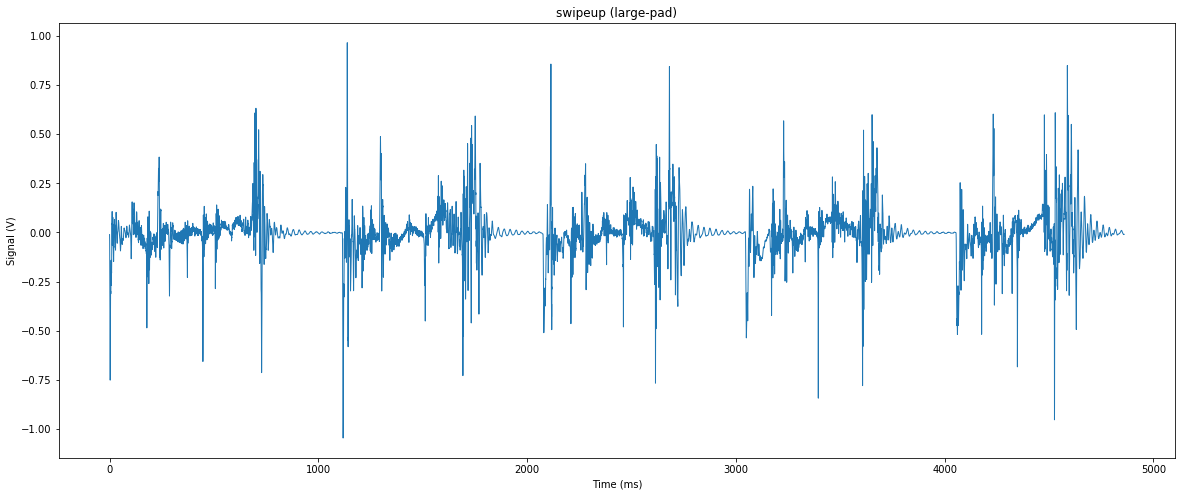

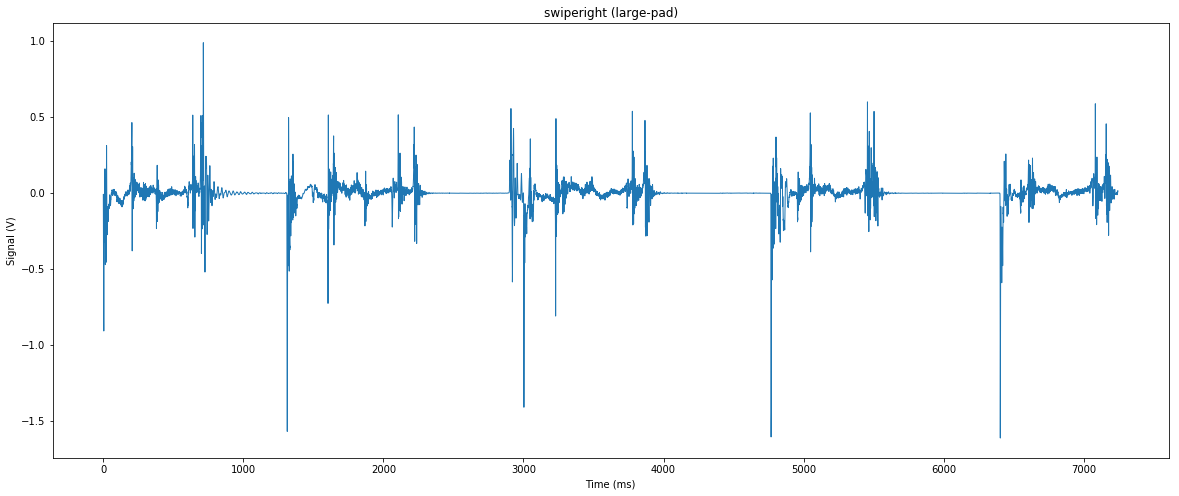

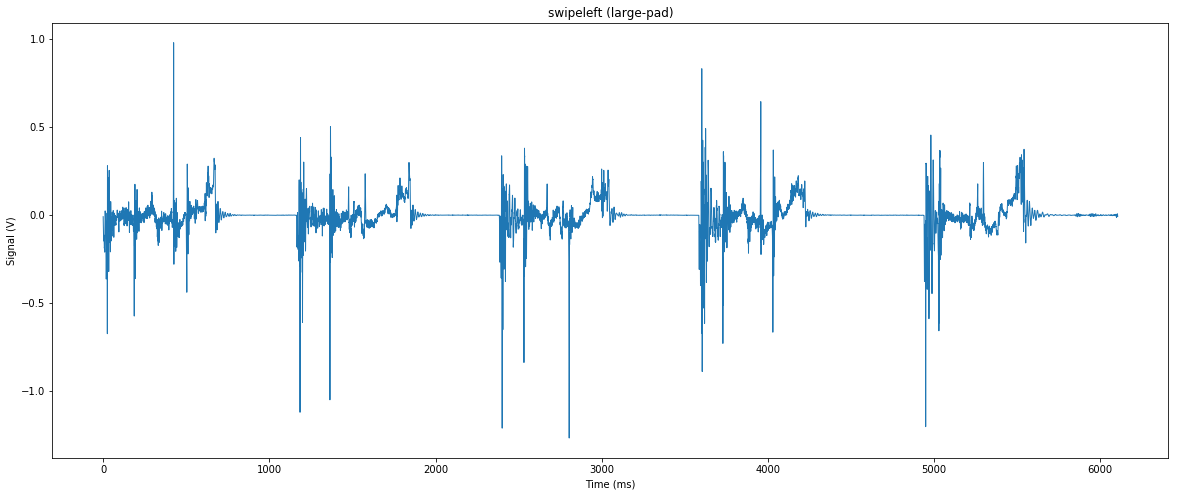

In [8]:
for (i, datum) in enumerate(data):
    df = load_dataset(datum)
    plt.figure(i)
    plt.ylabel('Signal (V)')
    plt.xlabel('Time (ms)')
    w = plt.plot([float(i)*(float(1)/50) for i in range(0, len(df))], df, linewidth=1.0)
    plt.title(datum['File'] + ' (' + datum['Dir'] + ')')

# Waveforms by Gesture

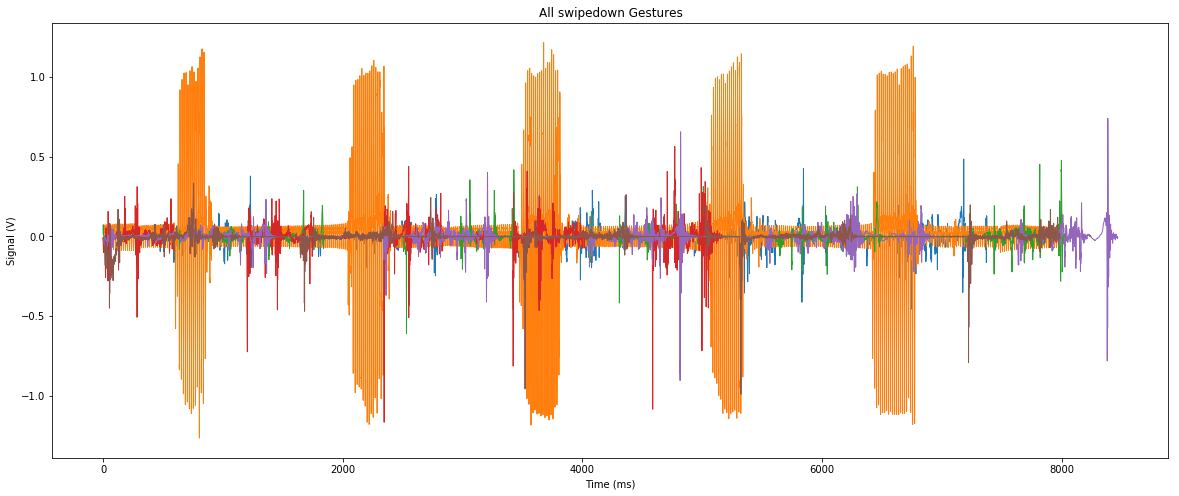

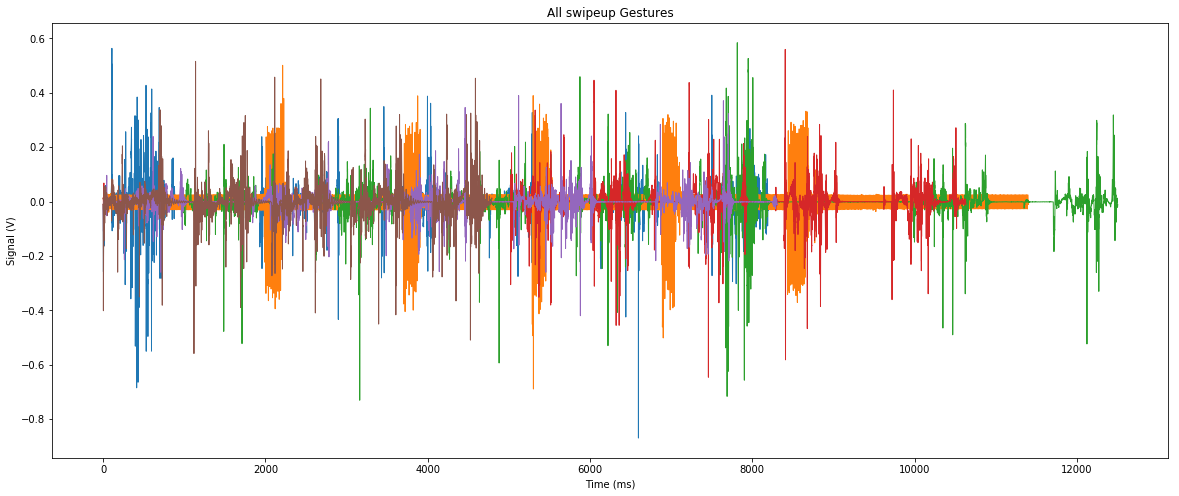

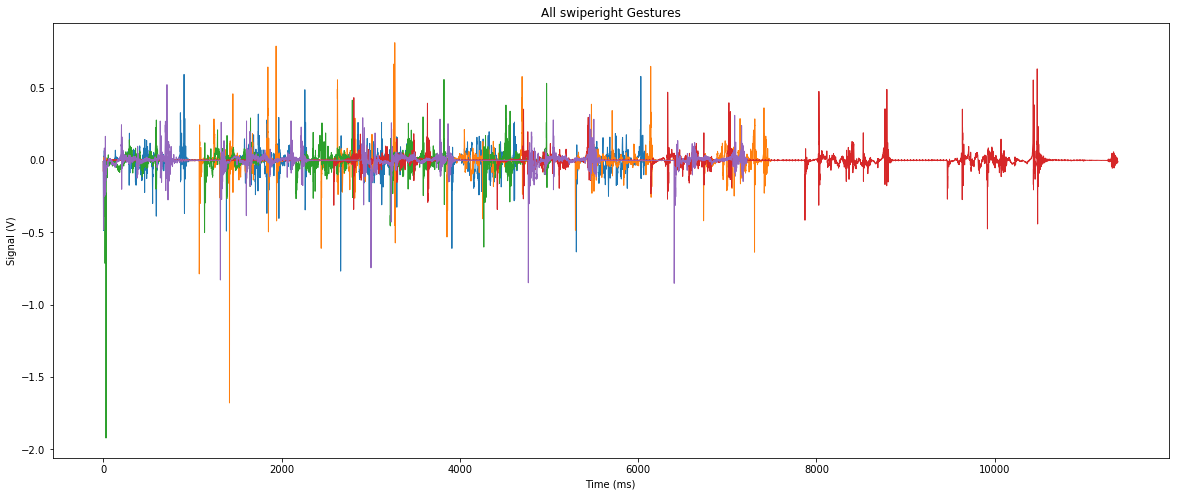

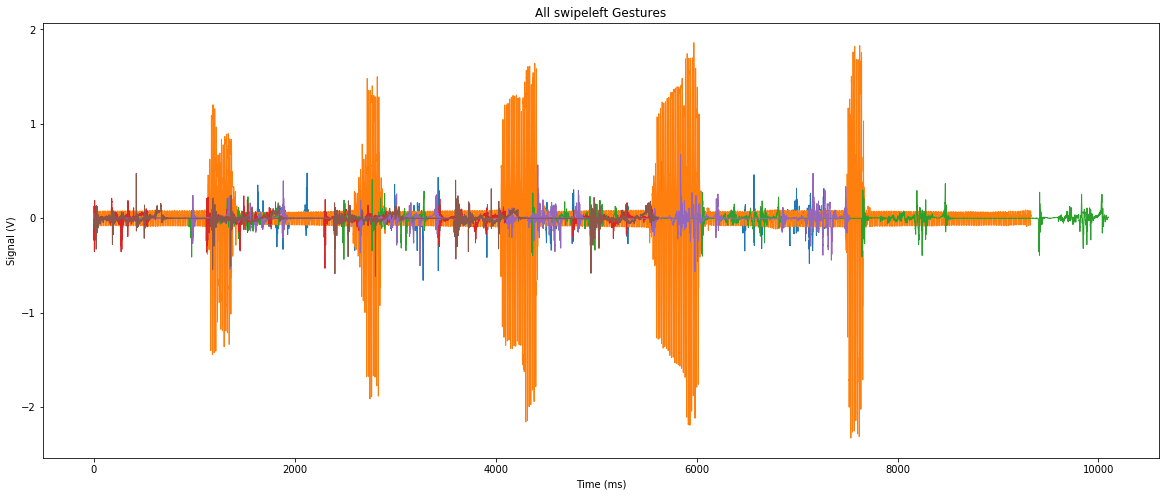

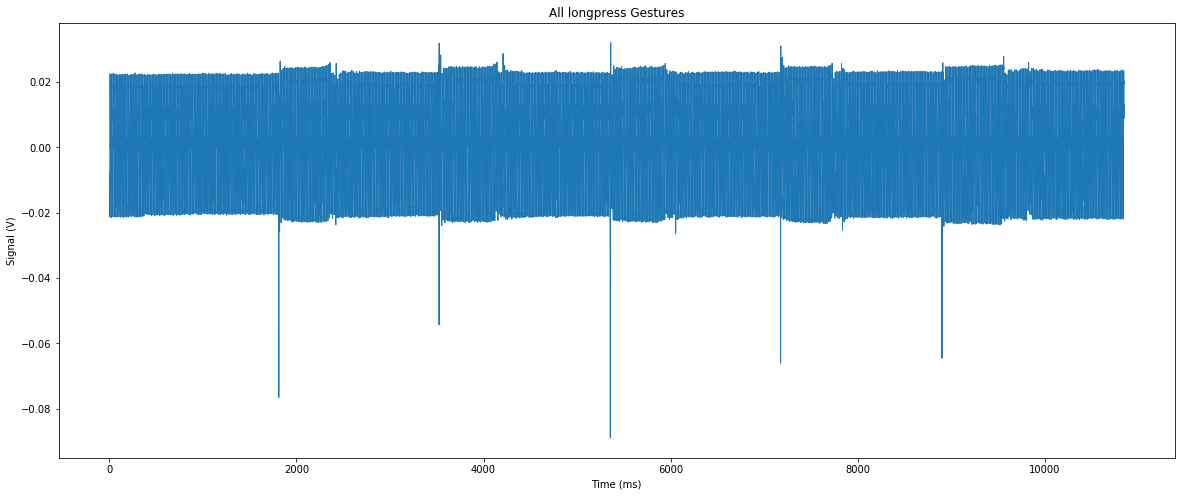

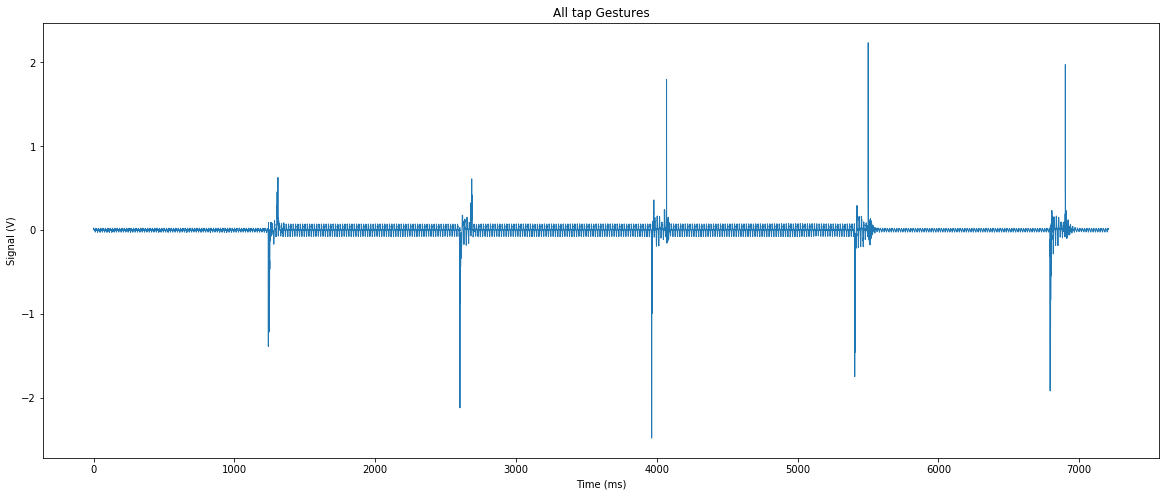

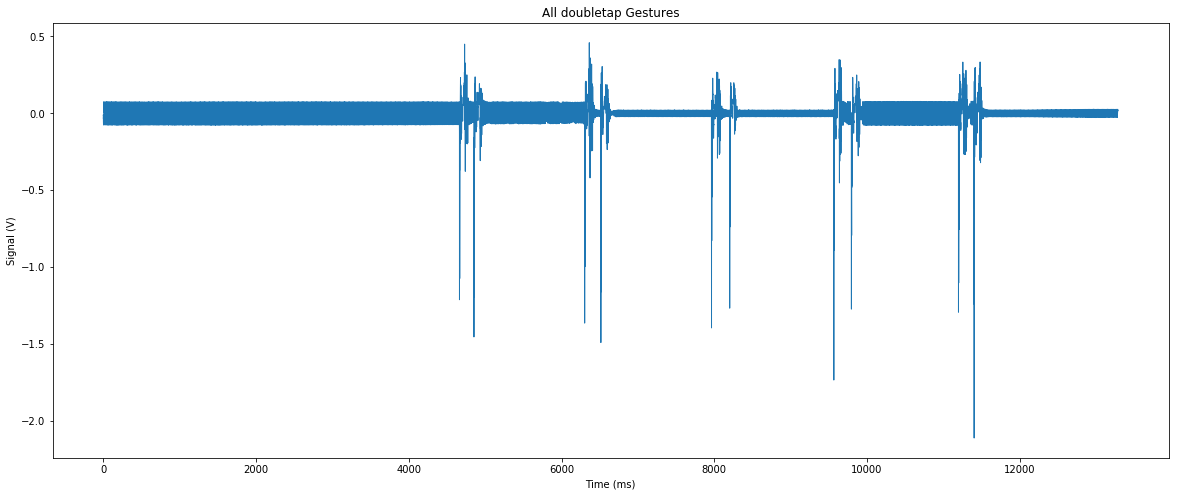

In [18]:
g = {}
for (i, datum) in enumerate(data):
    if datum['File'] not in g:
        g[datum['File']] = []
    g[datum['File']].append(datum)
for (i, gesture) in enumerate(g.keys()):
    gdata = g[gesture]
    plt.figure(i)
    plt.ylabel('Signal (V)')
    plt.xlabel('Time (ms)')
    for datum in gdata:
        df = load_dataset(datum)
        w = plt.plot([float(i)*(float(1)/50) for i in range(0, len(df))], df, linewidth=1.0, label=datum['Dir'])
    plt.title('All ' + gesture + ' Gestures')